_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: A. Shlychkov, A. Gittel, E. Seiffert

# Coding Lab 8



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style("whitegrid")
%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-07-02 12:15:58CEST

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.2

sklearn: 1.4.1.post1

numpy     : 1.26.4
matplotlib: 3.8.3
seaborn   : 0.13.2

Watermark: 2.4.3



# Task 1: Implement entropy estimators


*Grading: 5 pts (basic) + 1 pts (advanced) + 3 pts (bonus)*

## General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: $p(x=X) = \frac{1}{K}$

* "Zipf's law"- distribution: $p(x=X) = \frac{1}{Z x} $, where $Z = \sum_k 1/k$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


## Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


In [2]:
0 * np.log(0)

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_5272/2545229922.py:1: RuntimeWarning: divide by zero encountered in log
  0 * np.log(0)
/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_5272/2545229922.py:1: RuntimeWarning: invalid value encountered in scalar multiply
  0 * np.log(0)


nan

## Basic
*Grading: 5 pts*

In [3]:
def binary_to_integer(binarry_sequence):
    """
    input: binarry_sequence, np.array, shape=(d, )

    output: integer, int
    """
    return sum(2**i * bit for i, bit in enumerate(binarry_sequence[::-1]))


def integer_to_binary(n, d):
    """
    input: n, int
           d, int (length of the binary sequence)

    output: binary_sequence, np.array, shape=(d, )
    """
    binary_sequence = []

    # Generate the binary representation
    while n > 0:
        binary_sequence.append(n % 2)
        n = n // 2

    # Reverse the sequence to get the correct order
    binary_sequence.reverse()

    # Pad the sequence with leading zeros to ensure length d
    if len(binary_sequence) < d:
        binary_sequence = [0] * (d - len(binary_sequence)) + binary_sequence
    elif len(binary_sequence) > d:
        raise ValueError(f"Integer {n} cannot be represented in {d} bits.")

    return np.array(binary_sequence)


def sample_f_uniform_dist(n, d, rng=np.random.default_rng(0)):
    """
    input: n, number of samples
    input: d, number of bits
    input: rng, random number generator

    output: samples, np.array, shape=(n, d)
    """
    # generate n samples of d bits
    return rng.integers(0, 2, (n, d))


# def sample_f_zipf_dist(n, d, alpha=1.1, rng=np.random.default_rng(0)):
#     """
#     input: n, number of samples
#     input: d, number of bits
#     input: alpha, parameter of Zipf distribution
#     input: rng, random number generator

#     output: samples, np.array, shape=(n, d)
#     """
#     # generate n samples of d bits
#     return rng.zipf(a=alpha, size=(n, d)) % 2


def sample_f_zipf_manual_choice(n, num_bits, rng=np.random.default_rng(0)):
    """
    Generates samples from a Zipf distribution with the given alpha parameter using manual calculation,
    and samples either 1 or 0 based on the calculated probabilities.

    Parameters:
    - n: int, number of samples to generate
    - num_bits: int, number of bits in each sample
    - rng: np.random.Generator, random number generator

    Returns:
    - np.array, shape=(n, num_bits), binary samples
    """

    # # Function to calculate the harmonic number H_N
    # def harmonic_number(N):
    #     return np.sum(1.0 / np.arange(1, N + 1))

    # # Number of elements to consider for normalization constant Z
    # N = 1000000  # large number to approximate the infinite sum
    # Z = harmonic_number(N)

    # # Calculate probabilities p(x = k)
    # probabilities = np.zeros(num_bits)
    # for k in range(1, num_bits + 1):
    #     probabilities[k - 1] = 1 / (Z * k)

    N = 2**num_bits
    probabilities = 1 / (np.arange(0, N) + 1)  # true distribution
    probabilities = probabilities / np.sum(probabilities)  # normalize

    # Generate samples from the Zipf distribution and sample binary values
    # samples = np.zeros((n, num_bits), dtype=int)
    samples = []
    for i in range(n):

        # Sample from the Zipf distribution
        sample = rng.choice(np.arange(0, N), p=probabilities)
        sample = integer_to_binary(sample, num_bits)

        # Sample binary value based on the Zipf sample
        samples.append(sample)

    return np.array(samples)

### MLE

*Grading: 1 pts*

$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$

In [4]:
def entropy_mle(phat):
    """Maximum likelihood or plug-in estimator of discrete entropy

    Parameter
    ---------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    Return
    ------
    H: float
        Entropy estimate
    """
    # insert your code here (1 pt)
    # for phat = 0, the phat*log(phat) term is 0 instead of nan

    # Use np.where to handle the case where phat is 0

    # get all phat /= 0
    phat = phat[phat != 0]

    H = -np.sum(phat * np.log2(phat))

    return H

### Miller-Maddow corrected

*Grading: 1 pts*

$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$ 

$ \hat{d} = \#[\hat{p}(x)>0]$ 



In [5]:
def entropy_mm(phat, n):
    """Miller-Maddow corrected estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n:  int
        Number of samples


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    # calculate d hat as the number of phat > 0
    dhat = np.sum(phat > 0)

    H = entropy_mle(phat) + ((dhat - 1) / (2 * n))

    return H

### Jack-knife corrected

*Grading: 2 pts*

$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$ 

$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$

In [6]:
def entropy_jk(x, edges):
    """Jack-knife corrected estimator of discrete entropy

    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples

    edges: np.array, shape=(n_bins, )
        Histogram bin edges


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (2 pt)

    # calculate f
    x_int = np.apply_along_axis(binary_to_integer, 1, x)

    # calculate the histogram
    phat = np.histogram(x_int, bins=edges, density=True)[0]

    # calculate the number of samples
    n = len(x_int)

    # sanity check
    # print("Sampels: ", n, edges.shape, phat.shape, x_int.shape)

    # calculate the estimated entropy Hhat as a mean of each sample entropy
    Hhat = entropy_mle(phat)

    # initialize the sum of the entropy
    sum_H = 0

    # calculate the entropy left out sample
    for i in range(n):
        # calculate the phat without the ith sample
        x_int_i = np.delete(x_int, i)
        # calculate the histogram without the ith sample
        phat_i = np.histogram(x_int_i, bins=edges, density=True)[0]
        # calculate the entropy without the ith sample
        H_i = entropy_mle(phat_i)
        # add the entropy to the sum
        sum_H += H_i

    # Calculate H_hat_ml_mean
    H_hat_ml_mean = sum_H / n

    # calculate the jack-knife corrected entropy
    H = n * Hhat - (n - 1) * H_hat_ml_mean

    return H

### Coverage-adjusted

*Grading: 1 pts*

$C = 1 - \frac{\# f_{i}=1}{N}$

$\hat{P}_{C}= \hat{P}\cdot C$ 

$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$



In [7]:
def entropy_cae(phat, n):
    """coverage-adjusted estimator of discrete entropy

    Parameters
    ----------

    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram

    n: int
        Number of samples.


    Return
    ------

    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)

    # calculate number fo f_i = 1
    f = phat * n

    # calculate where f == 1
    f_i = np.sum(f == 1)

    # calculate C
    C = 1 - f_i / n

    # calculate P_c_hat
    P_c_hat = phat * C

    # calculate the coverage adjusted entropy
    # addjust for P_c_hat = 0  to avoid nan
    P_c_hat = P_c_hat[P_c_hat != 0]

    H = -np.sum((P_c_hat * np.log2(P_c_hat)) / (1 - (1 - P_c_hat) ** n))

    return H

## Advanced
*Grading: 1 + 3 pts*

### JVHW
*Grading: 1 pts*

In [8]:
# ### Necessary functions from https://github.com/EEthinker/JVHW_Entropy_Estimators/blob/b94ae17cc9410e0b781f3bfed2051b6004489176/Python/est_entro.py to run the JVHW entropy estimator

# import scipy.io

# #datapath to the polynomial coefficients given in the JVHW paper (poly_coeff_entro.mat)
# datapath = r"C:\Users\Arne.Gittel\Documents\Neuro Master\Neural data science\practicals\data\poly_coeff_entro.mat"
# poly_entro = None


# def formalize_sample(samp):
#     samp = np.array(samp)
#     if np.any(samp != np.fix(samp)):
#         raise ValueError("Input sample must only contain integers.")
#     if samp.ndim == 1 or samp.ndim == 2 and samp.shape[0] == 1:
#         samp = samp.reshape((samp.size, 1))
#     return samp


# def fingerprint(samp):
#     """A memory-efficient algorithm for computing fingerprint when wid is
#     large, e.g., wid = 100
#     """
#     wid = samp.shape[1]

#     d = np.r_[
#         np.full((1, wid), True, dtype=bool),
#         np.diff(np.sort(samp, axis=0), 1, 0) != 0,
#         np.full((1, wid), True, dtype=bool),
#     ]

#     f_col = []
#     f_max = 0

#     for k in range(wid):
#         a = np.diff(np.flatnonzero(d[:, k]))
#         a_max = a.max()
#         hist, _ = np.histogram(a, bins=a_max, range=(1, a_max + 1))
#         f_col.append(hist)
#         if a_max > f_max:
#             f_max = a_max

#     return np.array([np.r_[col, [0] * (f_max - len(col))] for col in f_col]).T


# def entro_mat(x, n, g_coeff, c_1):
#     # g_coeff = {g0, g1, g2, ..., g_K}, K: the order of best polynomial approximation,
#     K = len(g_coeff) - 1
#     thres = 4 * c_1 * np.log(n) / n
#     T, X = np.meshgrid(thres, x)
#     ratio = np.minimum(np.maximum(2 * X / T - 1, 0), 1)
#     q = np.arange(K).reshape((1, 1, K))
#     g = g_coeff.reshape((1, 1, K + 1))
#     MLE = -X * np.log(X) + 1 / (2 * n)
#     polyApp = np.sum(
#         np.concatenate(
#             (T[..., None], ((n * X)[..., None] - q) / (T[..., None] * (n - q))), axis=2
#         ).cumprod(axis=2)
#         * g,
#         axis=2,
#     ) - X * np.log(T)
#     polyfail = np.isnan(polyApp) | np.isinf(polyApp)
#     polyApp[polyfail] = MLE[polyfail]
#     output = ratio * MLE + (1 - ratio) * polyApp
#     return np.maximum(output, 0)


# def est_entro_JVHW(samp):
#     """Proposed JVHW estimate of Shannon entropy (in bits) of the input sample

#     This function returns a scalar JVHW estimate of the entropy of samp when
#     samp is a vector, or returns a row vector containing the JVHW estimate of
#     each column of samp when samp is a matrix.

#     Input:
#     ----- samp: a vector or matrix which can only contain integers. The input
#                 data type can be any interger classes such as uint8/int8/
#                 uint16/int16/uint32/int32/uint64/int64, or floating-point
#                 such as single/double.
#     Output:
#     ----- est: the entropy (in bits) of the input vector or that of each column
#                of the input matrix. The output data type is double.
#     """
#     samp = formalize_sample(samp)
#     [n, wid] = samp.shape
#     n = float(n)

#     # The order of polynomial is no more than 22 because otherwise floating-point error occurs
#     order = min(4 + int(np.ceil(1.2 * np.log(n))), 22)
#     global poly_entro
#     if poly_entro is None:
#         poly_entro = scipy.io.loadmat(
#             datapath
#         )["poly_entro"]
#     coeff = poly_entro[order - 1, 0][0]

#     f = fingerprint(samp)

#     prob = np.arange(1, f.shape[0] + 1) / n

#     # Piecewise linear/quadratic fit of c_1
#     V1 = np.array([0.3303, 0.4679])
#     V2 = np.array([-0.530556484842359, 1.09787328176926, 0.184831781602259])
#     f1nonzero = f[0] > 0
#     c_1 = np.zeros(wid)

#     with np.errstate(divide="ignore", invalid="ignore"):
#         if n >= order and f1nonzero.any():
#             if n < 200:
#                 c_1[f1nonzero] = np.polyval(V1, np.log(n / f[0, f1nonzero]))
#             else:
#                 n2f1_small = f1nonzero & (np.log(n / f[0]) <= 1.5)
#                 n2f1_large = f1nonzero & (np.log(n / f[0]) > 1.5)
#                 c_1[n2f1_small] = np.polyval(V2, np.log(n / f[0, n2f1_small]))
#                 c_1[n2f1_large] = np.polyval(V1, np.log(n / f[0, n2f1_large]))

#             # make sure nonzero threshold is higher than 1/n
#             c_1[f1nonzero] = np.maximum(c_1[f1nonzero], 1 / (1.9 * np.log(n)))

#         prob_mat = entro_mat(prob, n, coeff, c_1)

#     return np.sum(f * prob_mat, axis=0) / np.log(2)

In [19]:
### Necessary functions from https://github.com/EEthinker/JVHW_Entropy_Estimators/blob/b94ae17cc9410e0b781f3bfed2051b6004489176/Python/est_entro.py to run the JVHW entropy estimator
### Added comments using ChatGPT fur further understanding

import scipy.io

# Path to the polynomial coefficients file (poly_coeff_entro.mat)
datapath = "../poly_coeff_entro.mat"
poly_entro = None


def formalize_sample(samp):
    """Ensure the sample is in the correct format and contains only integers.

    This function checks if the input sample contains only integers and reshapes
    it to a column vector if it is a 1D array or a single-row 2D array.

    Input:
    ----- samp: A vector or matrix which should only contain integers. The input
                data type can be any integer class such as uint8/int8/uint16/
                int16/uint32/int32/uint64/int64, or floating-point such as
                single/double.

    Output:
    ----- samp: A 2D numpy array where each column represents a sequence from
                the input sample. The output ensures that the sample is a
                column vector if it was a 1D array or a single-row 2D array.
    """
    samp = np.array(samp)  # Convert input to a numpy array
    if np.any(samp != np.fix(samp)):  # Check if all elements are integers
        raise ValueError("Input sample must only contain integers.")
    if samp.ndim == 1 or (
        samp.ndim == 2 and samp.shape[0] == 1
    ):  # If the sample is a 1D array or a single row 2D array
        samp = samp.reshape((samp.size, 1))  # Reshape to a column vector
    return samp


def fingerprint(samp):
    """Compute the fingerprint of the sample, which is a histogram of frequencies of frequencies.

    The fingerprint function generates a histogram of frequencies of frequencies
    for each column in the sample. This is used to represent the sample in a
    more compact form which is useful for entropy estimation.

    Input:
    ----- samp: A 2D numpy array where each column represents a sequence. The
                input sample must only contain integers.

    Output:
    ----- f_col: A 2D numpy array where each column represents the fingerprint
                 histogram of the corresponding column in the input sample.
    """
    wid = samp.shape[1]  # Get the number of columns in the sample

    # Create a boolean array that marks the changes in sorted sample values
    d = np.r_[
        np.full((1, wid), True, dtype=bool),  # Add a row of True values at the top
        np.diff(np.sort(samp, axis=0), 1, 0) != 0,  # Mark changes in sorted sample
        np.full((1, wid), True, dtype=bool),  # Add a row of True values at the bottom
    ]

    f_col = []  # List to store fingerprint histograms for each column
    f_max = 0  # Maximum length of the differences

    for k in range(wid):  # Loop over each column
        # Compute the histogram of differences between non-zero entries
        a = np.diff(np.flatnonzero(d[:, k]))
        a_max = a.max()
        hist, _ = np.histogram(a, bins=a_max, range=(1, a_max + 1))
        f_col.append(hist)
        if a_max > f_max:  # Update the maximum length of differences
            f_max = a_max

    # Ensure all histograms have the same length by padding with zeros
    return np.array([np.r_[col, [0] * (f_max - len(col))] for col in f_col]).T


def entro_mat(x, n, g_coeff, c_1):
    """Calculate the entropy matrix using polynomial approximation.

    This function uses polynomial approximation to estimate the entropy for
    different probabilities based on the input polynomial coefficients and
    a threshold value.

    Input:
    ----- x: A 1D numpy array representing the probabilities of unique counts
             in the sample.
          n: The number of observations in the sample.
    g_coeff: A 1D numpy array containing the polynomial coefficients.
      c_1: A 1D numpy array containing the threshold values for each column
           in the sample.

    Output:
    ----- output: A 2D numpy array representing the entropy matrix for the input
                  probabilities. Each column corresponds to a column in the
                  input sample.
    """
    K = len(g_coeff) - 1  # Order of the polynomial
    thres = 4 * c_1 * np.log(n) / n  # Calculate the threshold value
    T, X = np.meshgrid(thres, x)  # Create a meshgrid for threshold and probabilities
    ratio = np.minimum(
        np.maximum(2 * X / T - 1, 0), 1
    )  # Calculate the ratio for interpolation

    # Prepare for polynomial approximation
    q = np.arange(K).reshape((1, 1, K))
    g = g_coeff.reshape((1, 1, K + 1))
    MLE = -X * np.log(X) + 1 / (2 * n)  # Calculate the Maximum Likelihood Estimation

    # Compute polynomial approximation
    polyApp = np.sum(
        np.concatenate(
            (T[..., None], ((n * X)[..., None] - q) / (T[..., None] * (n - q))), axis=2
        ).cumprod(
            axis=2
        )  # Cumulative product along the third axis
        * g,
        axis=2,
    ) - X * np.log(T)

    # Handle cases where polynomial approximation fails (NaN or Inf values)
    polyfail = np.isnan(polyApp) | np.isinf(polyApp)
    polyApp[polyfail] = MLE[polyfail]

    # Combine MLE and polynomial approximation using the ratio
    output = ratio * MLE + (1 - ratio) * polyApp
    return np.maximum(output, 0)  # Ensure the entropy values are non-negative


def est_entro_JVHW(samp):
    """Proposed JVHW estimate of Shannon entropy (in bits) of the input sample

    This function returns a scalar JVHW estimate of the entropy of samp when
    samp is a vector, or returns a row vector containing the JVHW estimate of
    each column of samp when samp is a matrix.

    Input:
    ----- samp: A vector or matrix which can only contain integers. The input
                data type can be any integer class such as uint8/int8/
                uint16/int16/uint32/int32/uint64/int64, or floating-point
                such as single/double.

    Output:
    ----- est: The entropy (in bits) of the input vector or that of each column
               of the input matrix. The output data type is double.
    """
    samp = formalize_sample(samp)  # Ensure sample format
    [n, wid] = samp.shape  # Get the number of rows (n) and columns (wid)
    n = float(n)  # Convert the number of rows to a float

    # Determine the order of the polynomial approximation
    order = min(4 + int(np.ceil(1.2 * np.log(n))), 22)

    # Load polynomial coefficients if not already loaded
    global poly_entro
    if poly_entro is None:
        poly_entro = scipy.io.loadmat(datapath)["poly_entro"]
    coeff = poly_entro[order - 1, 0][0]

    f = fingerprint(samp)  # Compute the fingerprint of the sample

    prob = np.arange(1, f.shape[0] + 1) / n  # Probability vector for each unique count

    # Piecewise linear/quadratic fit of c_1
    V1 = np.array([0.3303, 0.4679])  # Coefficients for small values of log(n/f[0])
    V2 = np.array(
        [-0.530556484842359, 1.09787328176926, 0.184831781602259]
    )  # Coefficients for large values of log(n/f[0])
    f1nonzero = (
        f[0] > 0
    )  # Boolean array indicating non-zero fingerprint values in the first row
    c_1 = np.zeros(wid)  # Initialize c_1 with zeros, one for each column

    with np.errstate(
        divide="ignore", invalid="ignore"
    ):  # Ignore divide by zero and invalid value warnings
        if n >= order and f1nonzero.any():
            if n < 200:  # Use linear fit for small sample sizes
                c_1[f1nonzero] = np.polyval(V1, np.log(n / f[0, f1nonzero]))
            else:  # Use piecewise quadratic/linear fit for larger sample sizes
                n2f1_small = f1nonzero & (np.log(n / f[0]) <= 1.5)
                n2f1_large = f1nonzero & (np.log(n / f[0]) > 1.5)
                c_1[n2f1_small] = np.polyval(V2, np.log(n / f[0, n2f1_small]))
                c_1[n2f1_large] = np.polyval(V1, np.log(n / f[0, n2f1_large]))

            # Ensure non-zero threshold is higher than 1/n
            c_1[f1nonzero] = np.maximum(c_1[f1nonzero], 1 / (1.9 * np.log(n)))

        # Compute the entropy matrix for the probabilities
        prob_mat = entro_mat(prob, n, coeff, c_1)

    # Return the estimated entropy in bits
    return np.sum(f * prob_mat, axis=0) / np.log(2)

In [10]:
def entropy_jvhw(x):
    """JVHW estimator of discrete entropy.

    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples

    Return
    ------
    H: float
        Entropy estimate
    """

    # insert your code here (1 pt)
    # Use the JVHW estimator form https://github.com/EEthinker/JVHW_Entropy_Estimators/blob/b94ae17cc9410e0b781f3bfed2051b6004489176/Python/est_entro.py to estimate the entropy of the samples
    H = est_entro_JVHW(x)

    return H

### Bonus points: Unseen or Best Upper Bounds estimator
*Grading: 3 bonus pts*

In [11]:
from scipy.optimize import linprog
from scipy.stats import poisson

# Python implementations of Algorithm 1. of the Matlab code provided for the unseen entropy estimator (Estimating the Unseen: Improved Estimators for Entropy and other Properties; Valiant et.al) with increased number of maximum iterations


def unseen(f):
    """
    Approximates the 'histogram' of a true distribution based on a fingerprint.

    Input:
    f -- fingerprint of a sample, where f[i] represents the number of elements that appear i times

    Output:
    histx -- approximation of the histogram of the true distribution, where histx[i] represents the number of domain elements
             that occur with probability x[i]
    x -- probabilities corresponding to histx

    Notes:
    This function approximates the histogram of the true distribution based on the provided fingerprint f.
    The sum of probabilities times their respective counts equals 1, ensuring the total probability mass is conserved.
    An estimation of the entropy of the true distribution can be computed using: Entropy = (-1) * sum(histx * x * log(x))
    """

    f = np.array(f).flatten()
    k = np.dot(f, np.arange(1, len(f) + 1))

    # Algorithm parameters
    gridFactor = 1.1
    alpha = 0.5
    xLPmin = 1 / (k * max(10, k))
    maxLPIters = 100000

    # Split the fingerprint
    x = [0]
    histx = [0]
    fLP = np.zeros(len(f))

    for i in range(len(f)):
        if f[i] > 0:
            wind = [
                max(0, i - int(np.ceil(np.sqrt(i)))),
                min(i + int(np.ceil(np.sqrt(i))) + 1, len(f)),
            ]
            if sum(f[wind[0] : wind[1]]) < 2 * np.sqrt(i):
                x.append(i / k)
                histx.append(f[i])
                fLP[i] = 0
            else:
                fLP[i] = f[i]

    # If no LP portion, return the empirical histogram
    fmax = np.max(np.where(fLP > 0))
    if fmax == 0:
        return np.array(x[1:]), np.array(histx[1:])

    # Set up the first LP
    LPmass = 1 - np.dot(x, histx)
    fLP = np.append(fLP[:fmax], np.zeros(int(np.ceil(np.sqrt(fmax)))))
    szLPf = len(fLP)
    xLPmax = fmax / k
    xLP = xLPmin * gridFactor ** np.arange(
        int(np.ceil(np.log(xLPmax / xLPmin) / np.log(gridFactor))) + 1
    )
    szLPx = len(xLP)

    objf = np.zeros(szLPx + 2 * szLPf)
    objf[szLPx : szLPx + 2 * szLPf : 2] = 1 / np.sqrt(fLP + 1)
    objf[szLPx + 1 : szLPx + 2 * szLPf : 2] = 1 / np.sqrt(fLP + 1)

    A = np.zeros((2 * szLPf, szLPx + 2 * szLPf))
    b = np.zeros(2 * szLPf)
    for i in range(szLPf):
        A[2 * i, :szLPx] = poisson.pmf(i + 1, k * xLP)
        A[2 * i + 1, :szLPx] = -A[2 * i, :szLPx]
        A[2 * i, szLPx + 2 * i] = -1
        A[2 * i + 1, szLPx + 2 * i + 1] = -1
        b[2 * i] = fLP[i]
        b[2 * i + 1] = -fLP[i]

    Aeq = np.zeros(szLPx + 2 * szLPf)
    Aeq[:szLPx] = xLP
    beq = LPmass

    options = {"maxiter": maxLPIters, "disp": False}

    for i in range(szLPx):
        A[:, i] /= xLP[i]
        Aeq[i] /= xLP[i]

    sol = linprog(
        objf,
        A_ub=A,
        b_ub=b,
        A_eq=Aeq[np.newaxis, :],
        b_eq=[beq],
        bounds=[(0, None)] * (szLPx + 2 * szLPf),
        options=options,
    )
    if sol.status == 0:
        print("Maximum number of iterations reached--try increasing maxLPIters")
    if sol.status < 0:
        print("LP1 solution was not found, still solving LP2 anyway...")

    # Solve the 2nd LP
    objf2 = np.zeros_like(objf)
    objf2[:szLPx] = 1
    A2 = np.vstack([A, objf])
    b2 = np.append(b, sol.fun + alpha)
    for i in range(szLPx):
        objf2[i] /= xLP[i]

    sol2 = linprog(
        objf2,
        A_ub=A2,
        b_ub=b2,
        A_eq=Aeq[np.newaxis, :],
        b_eq=[beq],
        bounds=[(0, None)] * (szLPx + 2 * szLPf),
        options=options,
    )
    if sol2.status != 1:
        print("LP2 solution was not found")

    # Append LP solution to empirical portion of histogram
    sol2.x[:szLPx] /= xLP
    x.extend(xLP)
    histx.extend(sol2.x)
    x, histx = np.array(x), np.array(histx)
    ind = np.argsort(x)
    x = x[ind]
    histx = histx[ind]
    ind = histx > 0
    x = x[ind]
    histx = histx[ind]

    return histx, x


def makeFinger(v):
    """
    Creates a fingerprint vector from an input vector of integers.

    Input:
    v -- vector of integers

    Output:
    f -- fingerprint vector, where f[i] represents the number of elements that occur exactly i times in vector v

    Notes:
    This function generates a fingerprint vector from the input vector v.
    For each integer i, f[i] counts how many elements in v occur exactly i times.
    """

    h1 = np.histogram(v, bins=np.arange(min(v), max(v) + 2))[0]
    f = np.histogram(h1, bins=np.arange(max(h1) + 2))[0]
    return f[1:]

In [12]:
def estimate_unseen_entropy(samp):
    """
    Estimate the entropy of a sample using the Unseen estimator.

    Parameters
    ----------
    samp : list of integers
        The sample to estimate the entropy of.

    Returns
    -------
    float
        The estimated entropy of the sample.

    """
    f = makeFinger(samp)
    histx, x = unseen(f)
    return -np.sum(histx * x * np.log2(x))


# Test for unseen estimator
n = 1024
k = 10000
samp = np.random.randint(1, n + 1, k)
print(samp.shape)
# Compute corresponding fingerprint
f = makeFinger(samp)

# Estimate distribution from which sample was drawn
h, x = unseen(f)

# Output entropy of the true distribution Unif[n]
trueEntropy = np.log2(n)
print("True entropy:", trueEntropy)

# Output entropy of the empirical distribution of the sample
empiricalEntropy = -np.dot(
    f, ((np.arange(1, len(f) + 1) / k) * np.log2(np.arange(1, len(f) + 1) / k))
)
print("Empirical entropy:", empiricalEntropy)

# Output entropy of the recovered histogram [h, x]
estimatedEntropy = -np.dot(h, x * np.log2(x))
print("Estimated entropy:", estimatedEntropy)

entr = estimate_unseen_entropy(samp)
print("Estimated entropy:", entr)
p_test = 1 / n * np.ones(n)  # true distribution

H_test = -np.sum(p_test * np.log2(p_test))  # true entropy)
print("True entropy:", H_test)

(10000,)
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
True entropy: 10.0
Empirical entropy: 9.92683638874989
Estimated entropy: 9.990407741930627
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Estimated entropy: 9.990407741930627
True entropy: 10.0


# Task 2: Distributions
*Grading: 4 pts*

## Uniform distribution
*Grading: 2 pts*

In [13]:
D = 10  # sequence length
N = 2**D  # number of possible sequences

p = 1 / N * np.ones(N)  # true distribution

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

(1024,) (100,) [ 897 1023  411  592   29  631  943   54  826  305  306  698  686  946
  964  220  788  497  997  821] (10000,)


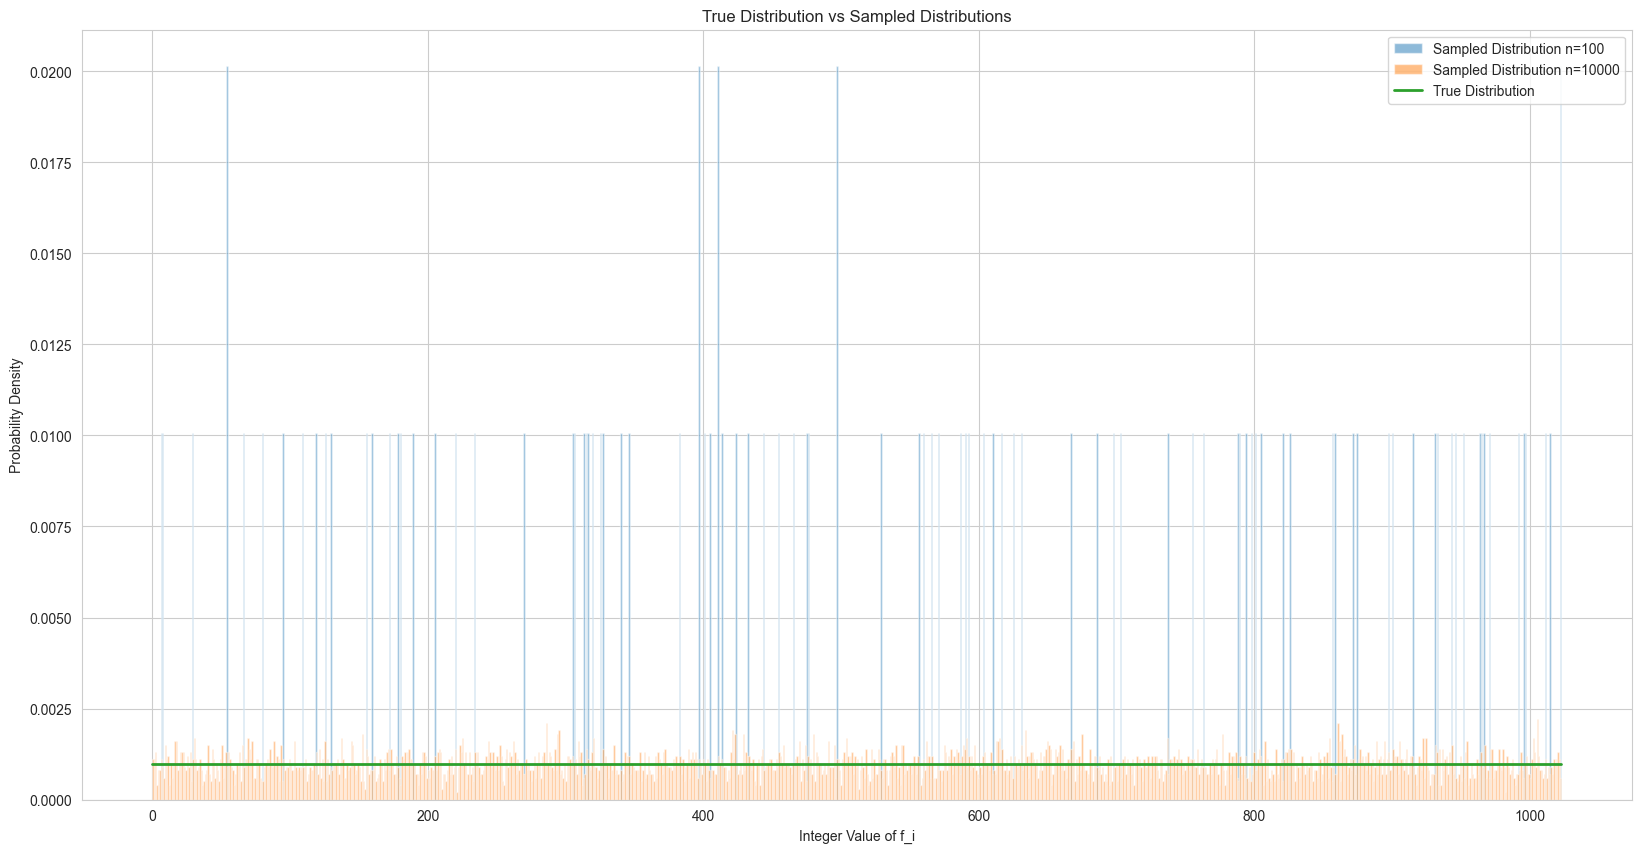

In [14]:
# insert your code here
rng = np.random.default_rng(0)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
n1 = 100
x_100 = sample_f_uniform_dist(n1, D, rng)
x_100_int = np.apply_along_axis(binary_to_integer, 1, x_100)

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------
n2 = 10000
x_1000 = sample_f_uniform_dist(n2, D, rng)
x_1000_int = np.apply_along_axis(binary_to_integer, 1, x_1000)

# ------------------------------------
# Plot the true distribution and
# the sampled distributions. (0.5 pts)
# ------------------------------------

print(p.shape, x_100_int.shape, x_100_int[:20], x_1000_int.shape)
# Plot the true distribution and the sampled distributions
hist_bins = N
plt.figure(figsize=(20, 10))
plt.hist(
    x_100_int,
    bins=hist_bins,
    density=True,
    alpha=0.5,
    label="Sampled Distribution n=100",
)
plt.hist(
    x_1000_int,
    bins=hist_bins,
    density=True,
    alpha=0.5,
    label="Sampled Distribution n=10000",
)


# Plot the true uniform distribution for reference
plt.plot(p, label="True Distribution", lw=2)
# plt.hist(p, bins=hist_bins, density=True, alpha=0.5, label="True Distribution")

plt.legend()
plt.xlabel("Integer Value of f_i")
plt.ylabel("Probability Density")
plt.title("True Distribution vs Sampled Distributions")
plt.show()

In [15]:
print(x_100[:10], x_100_int[:10])

[[1 1 1 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 0 1 1 0 1 1]
 [1 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 1]
 [1 0 0 1 1 1 0 1 1 1]
 [1 1 1 0 1 0 1 1 1 1]
 [0 0 0 0 1 1 0 1 1 0]
 [1 1 0 0 1 1 1 0 1 0]
 [0 1 0 0 1 1 0 0 0 1]] [ 897 1023  411  592   29  631  943   54  826  305]


### To do: what I notice ###


Larger samplesize capture the true underlying distribution better.

When sample size << than possible number of bit combinations (here 1024) some probabilitys are by default to high even when they only occure once while others do not occure at all.


Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [20]:
sample_sizes = np.round(np.logspace(1, 5, num=10))

n_runs = 30
rng = np.random.default_rng(1)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))
h_unseen = np.zeros((len(sample_sizes), n_runs))
# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------
        # sample from the uniform distribution using sample size S and sequence length D
        x = sample_f_uniform_dist(int(S), D, rng)
        # convert the binary sequences to integer f
        x_int = np.apply_along_axis(binary_to_integer, 1, x)
        # calculate the histogram
        phat = np.histogram(x_int, bins=edges, density=True)[0]
        # print(np.sum(phat), len(phat), phat * S, np.sum(phat * S))
        # insert your code here
        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        # print(x_int.shape, x_int[:10], phat.shape, phat[:10], make_finger(x_int, edges))
        # h_unseen[i, j] = unseen_estimator(x_int, int(S))
        # print("here", phat * D, np.sum(phat * D))
        h_unseen[i, j] = estimate_unseen_entropy(x_int)

        # cap the number of samples to 1000 for the jack-knife estimator
        if x_int.shape[0] > 1000:
            x = x[:1000]

        # print(entropy_jk(x, edges))
        h_jk[i, j] = entropy_jk(x, edges)
        # print(entropy_jvhw(x))
        h_jvhw[i, j] = entropy_jvhw(x_int)

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_5272/2925346207.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h_jvhw[i, j] = entropy_jvhw(x_int)


Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found

Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

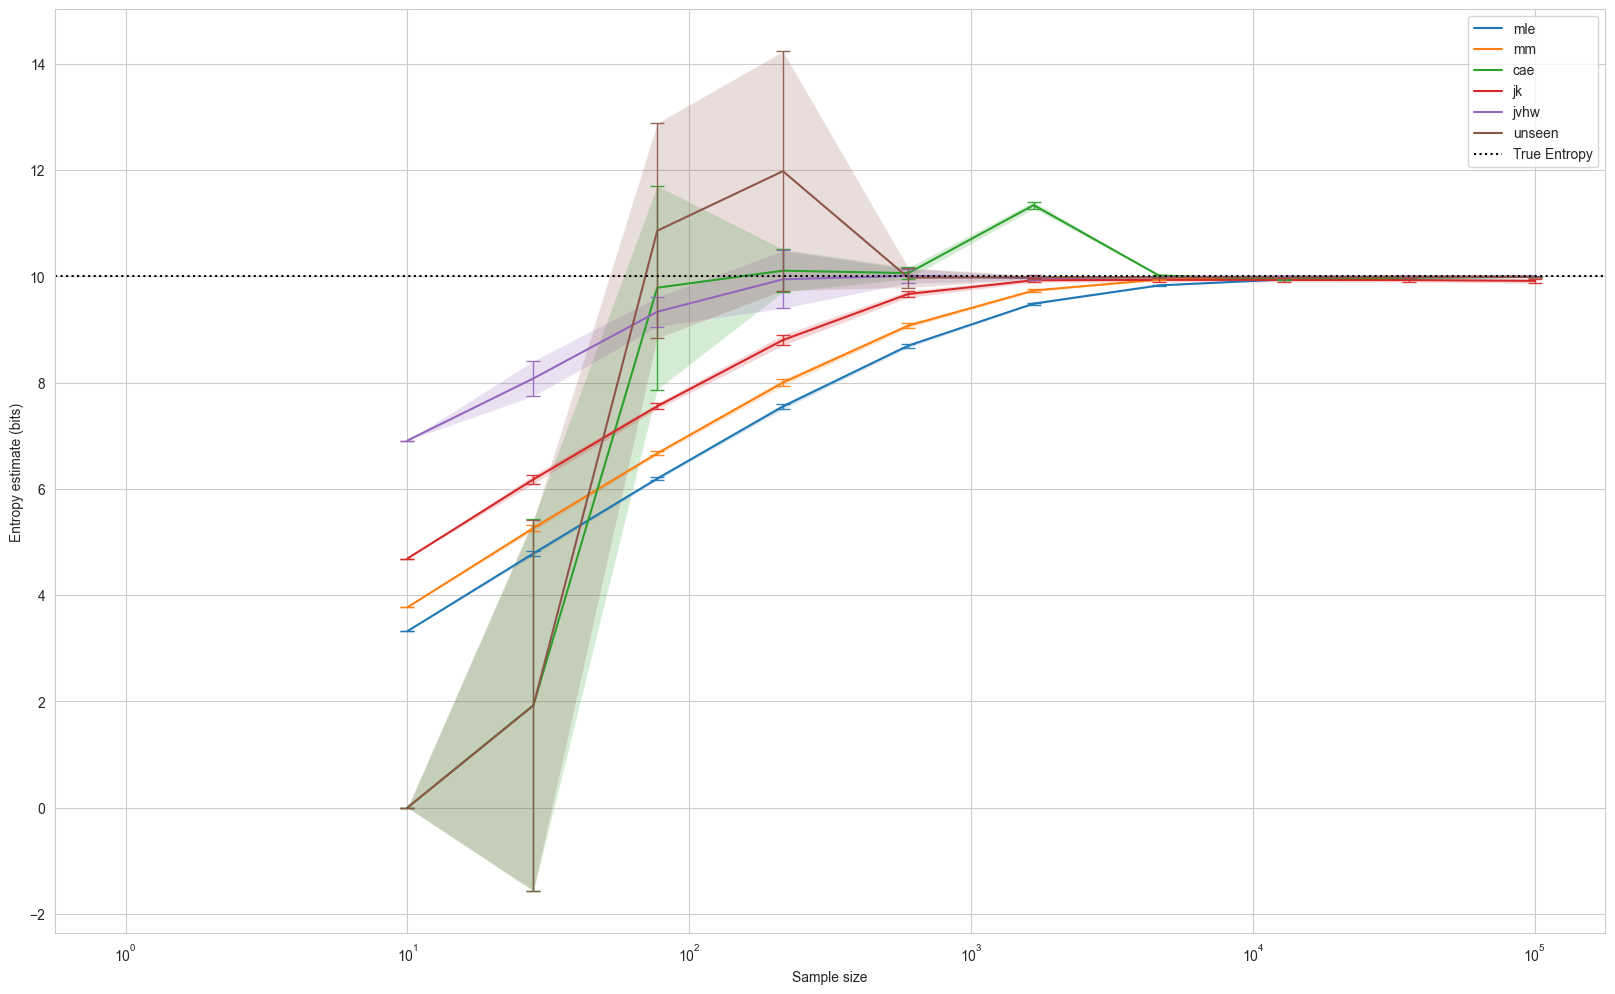

In [21]:
plt.figure(figsize=(20, 12))

plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")
plt.semilogx(sample_sizes, np.mean(h_unseen, axis=1), label="unseen")

# plot the standard deviation
plt.fill_between(
    sample_sizes,
    np.mean(h_mle, axis=1) - np.std(h_mle, axis=1),
    np.mean(h_mle, axis=1) + np.std(h_mle, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_mm, axis=1) - np.std(h_mm, axis=1),
    np.mean(h_mm, axis=1) + np.std(h_mm, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_cae, axis=1) - np.std(h_cae, axis=1),
    np.mean(h_cae, axis=1) + np.std(h_cae, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_jk, axis=1) - np.std(h_jk, axis=1),
    np.mean(h_jk, axis=1) + np.std(h_jk, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_jvhw, axis=1) - np.std(h_jvhw, axis=1),
    np.mean(h_jvhw, axis=1) + np.std(h_jvhw, axis=1),
    alpha=0.2,
)

plt.fill_between(
    sample_sizes,
    np.mean(h_unseen, axis=1) - np.std(h_unseen, axis=1),
    np.mean(h_unseen, axis=1) + np.std(h_unseen, axis=1),
    alpha=0.2,
)

plt.errorbar(
    sample_sizes,
    np.mean(h_mle, axis=1),
    yerr=np.std(h_mle, axis=1),
    fmt="none",  # Do not plot points, only error bars
    capsize=5,  # Size of error bar caps
    elinewidth=1,  # Thickness of error bar lines
    alpha=0.9,  # Transparency
    color="C0",  # Match color with 'mle' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_mm, axis=1),
    yerr=np.std(h_mm, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C1",  # Match color with 'mm' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_cae, axis=1),
    yerr=np.std(h_cae, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C2",  # Match color with 'cae' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_jk, axis=1),
    yerr=np.std(h_jk, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C3",  # Match color with 'jk' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_jvhw, axis=1),
    yerr=np.std(h_jvhw, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C4",  # Match color with 'jvhw' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_unseen, axis=1),
    yerr=np.std(h_unseen, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C5",  # Match color with 'unseen' line
)

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":", label="True Entropy")
plt.xlabel("Sample size")
plt.ylabel("Entropy estimate (bits)")

plt.legend()

JVHW and Jack knive estimators perform best for smaller sample sizes

## Zipf distribution
*Grading: 2 pts*

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [22]:
D = 10
N = 2**D

p = 1 / (np.arange(0, N) + 1)  # true distribution
p = p / np.sum(p)

H = -np.sum(p * np.log2(p))  # true entropy

print(H)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `choice` of numpys random number generator is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

(1024,) (100, 10) [[0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 1 1 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1 0 1]
 [0 0 0 0 1 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1 0 1]
 [0 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 1]
 [0 0 0 1 0 1 1 1 1 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]] (10000,)


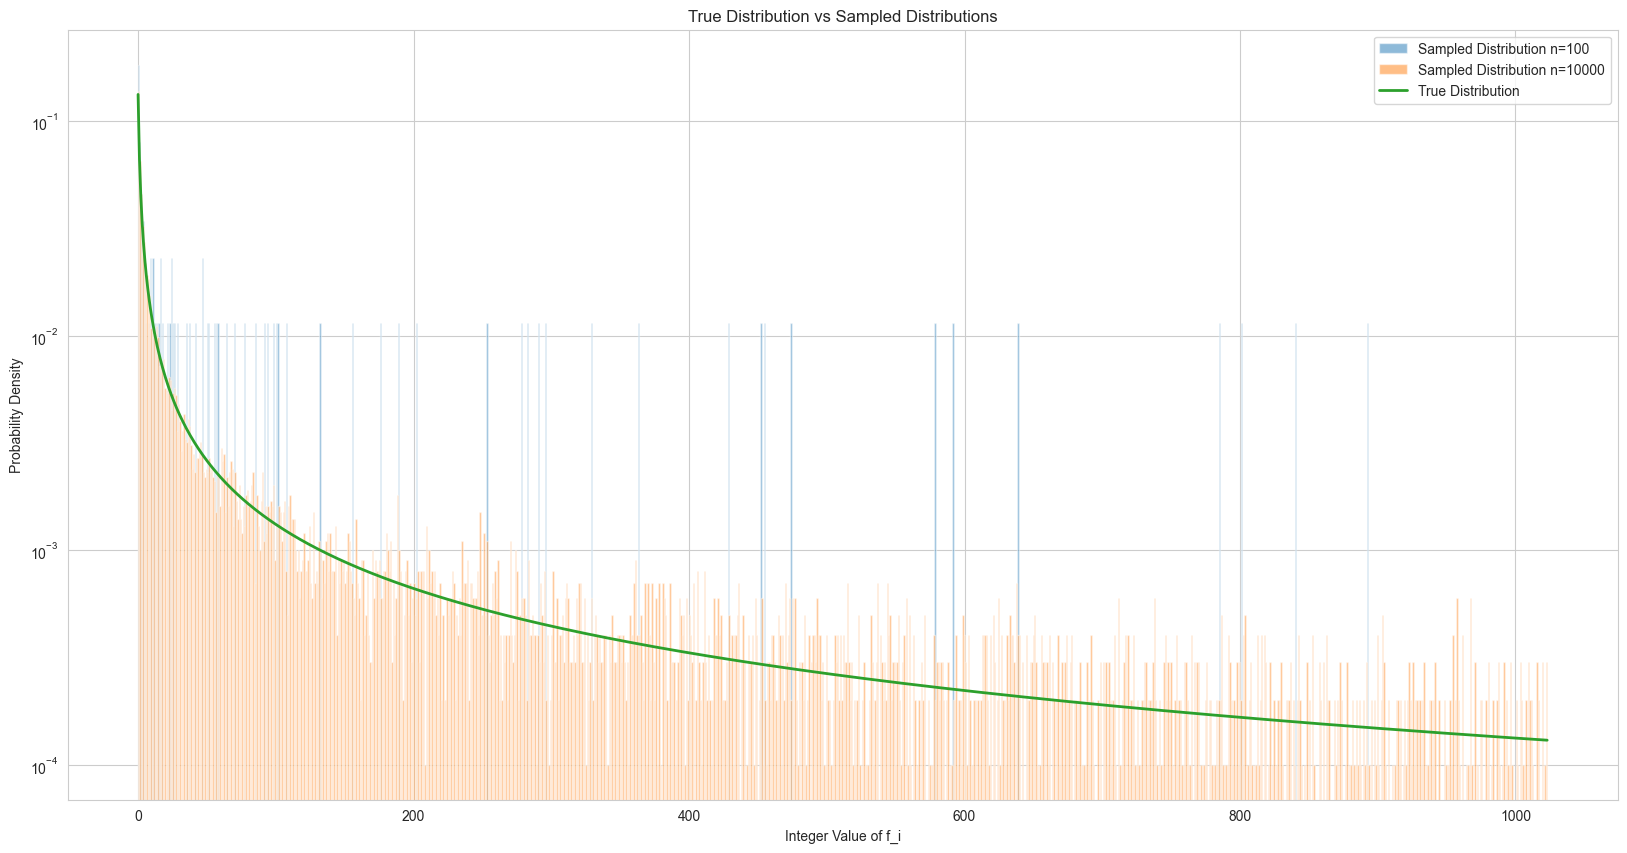

In [23]:
# insert your code here
rng = np.random.default_rng(2)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------
x_z_100 = sample_f_zipf_manual_choice(n1, D, rng=rng)
x_z_100_int = np.apply_along_axis(binary_to_integer, 1, x_z_100)


# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------
x_z_10000 = sample_f_zipf_manual_choice(n2, D, rng=rng)
x_z_10000_int = np.apply_along_axis(binary_to_integer, 1, x_z_10000)


print(p.shape, x_z_100.shape, x_z_100[:20], x_z_10000_int.shape)
# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------

# Plot the true distribution and the sampled distributions
hist_bins = N
plt.figure(figsize=(20, 10))
plt.hist(
    x_z_100_int,
    bins=hist_bins,
    density=True,
    alpha=0.5,
    label="Sampled Distribution n=100",
)
plt.hist(
    x_z_10000_int,
    bins=hist_bins,
    density=True,
    alpha=0.5,
    label="Sampled Distribution n=10000",
)

# Plot the true uniform distribution for reference
plt.plot(p, label="True Distribution", lw=2)

# make y log scale
plt.yscale("log")
plt.legend()
plt.xlabel("Integer Value of f_i")
plt.ylabel("Probability Density")
plt.title("True Distribution vs Sampled Distributions")
plt.show()

 What do we notice:

Same problem regarding sample size we have seen for the uniform distribution, now we see that the probabilitys in the low sample size the sampled values appear ~equally likely (if sampled once) but spread differently over the range of possible integer values (higher values have less amount of sampled values). Even with large sample sizes we see, that for the larger integer values with a very low probability the sampling becomes less accurate.

Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [24]:
sample_sizes = np.round(np.logspace(1, 5, num=10))
n_runs = 30
rng = np.random.default_rng(3)

edges = np.arange(-0.5, N, 1)

h_mle = np.zeros((len(sample_sizes), n_runs))
h_mm = np.zeros((len(sample_sizes), n_runs))
h_jk = np.zeros((len(sample_sizes), n_runs))
h_cae = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))
h_unseen = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):

        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------

        # insert your code here

        # sample from the Zipf distribution using sample size S and sequence length D
        x = sample_f_zipf_manual_choice(int(S), D, rng)
        # convert the binary sequences to integer f
        x_int = np.apply_along_axis(binary_to_integer, 1, x)
        # calculate the histogram
        phat = np.histogram(x_int, bins=edges, density=True)[0]
        # print(np.sum(phat), len(phat))
        # insert your code here
        h_mle[i, j] = entropy_mle(phat)
        h_mm[i, j] = entropy_mm(phat, S)
        h_cae[i, j] = entropy_cae(phat, S)
        h_unseen[i, j] = estimate_unseen_entropy(x_int)
        # cap the number of samples to 1000 for the jack-knife estimator
        if x_int.shape[0] > 1000:
            x = x[:1000]
        h_jk[i, j] = entropy_jk(x, edges)
        h_jvhw[i, j] = entropy_jvhw(x_int)

Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_5272/3378086709.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h_jvhw[i, j] = entropy_jvhw(x_int)


Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found
Maximum number of iterations reached--try increasing maxLPIters
LP2 solution was not found

Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

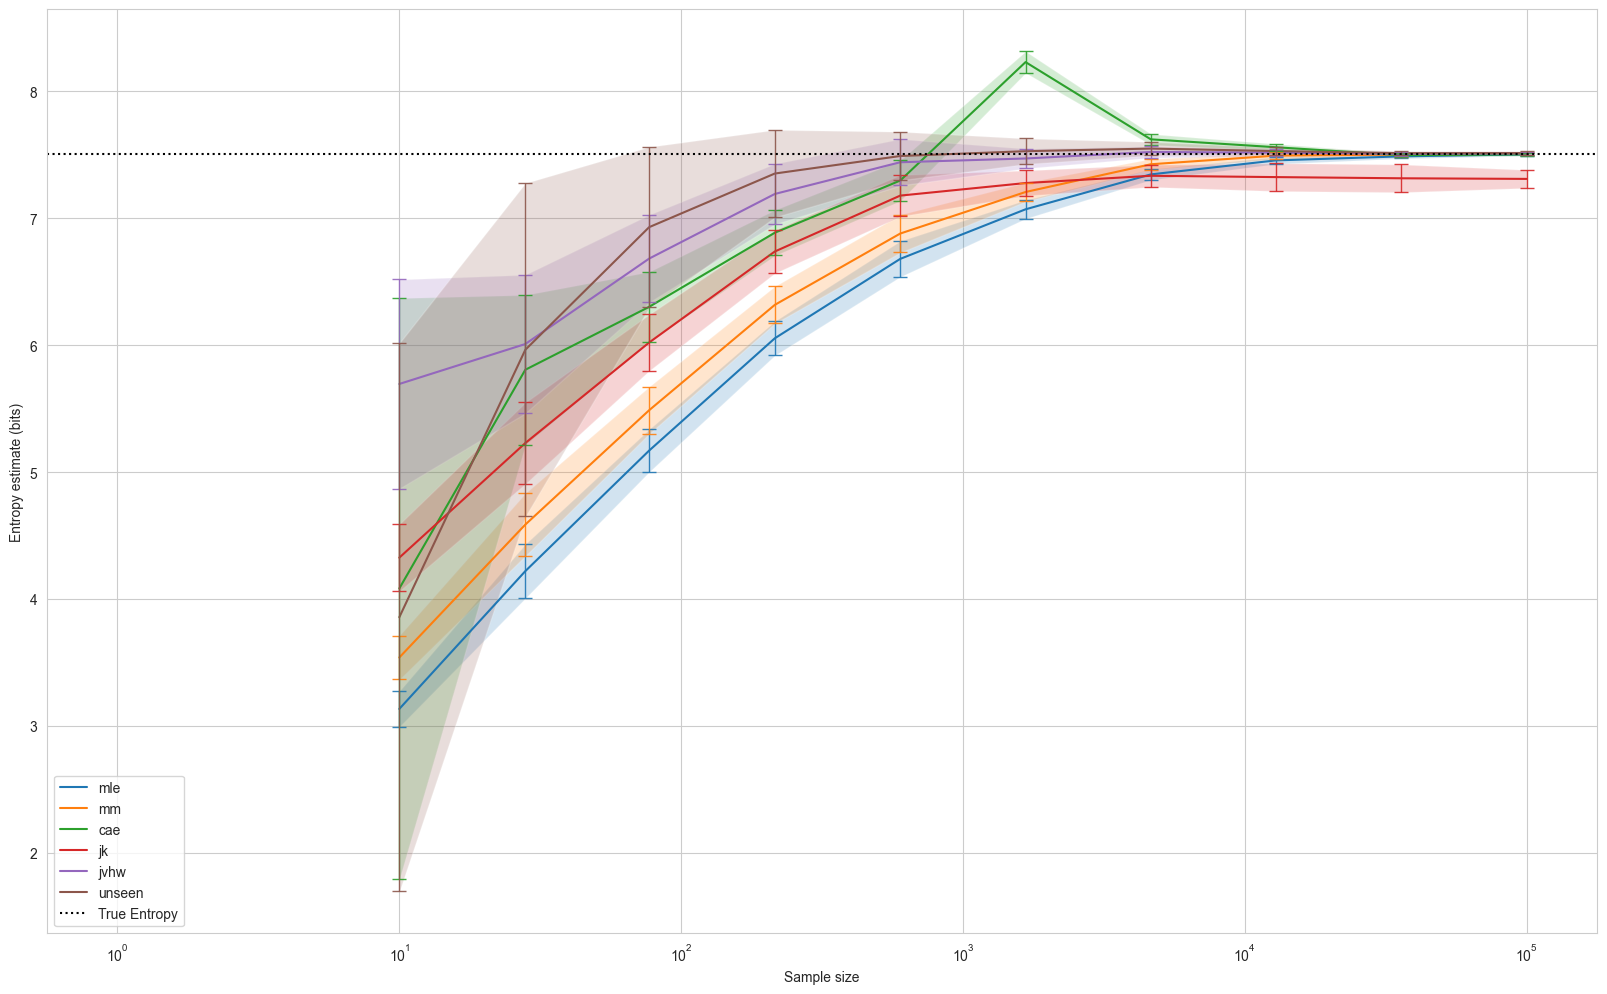

In [25]:
plt.figure(figsize=(20, 12))


plt.semilogx(sample_sizes, np.mean(h_mle, axis=1), label="mle")
plt.semilogx(sample_sizes, np.mean(h_mm, axis=1), label="mm")
plt.semilogx(sample_sizes, np.mean(h_cae, axis=1), label="cae")
plt.semilogx(sample_sizes, np.mean(h_jk, axis=1), label="jk")
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label="jvhw")
plt.semilogx(sample_sizes, np.mean(h_unseen, axis=1), label="unseen")

# plot the standard deviation
plt.fill_between(
    sample_sizes,
    np.mean(h_mle, axis=1) - np.std(h_mle, axis=1),
    np.mean(h_mle, axis=1) + np.std(h_mle, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_mm, axis=1) - np.std(h_mm, axis=1),
    np.mean(h_mm, axis=1) + np.std(h_mm, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_cae, axis=1) - np.std(h_cae, axis=1),
    np.mean(h_cae, axis=1) + np.std(h_cae, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_jk, axis=1) - np.std(h_jk, axis=1),
    np.mean(h_jk, axis=1) + np.std(h_jk, axis=1),
    alpha=0.2,
)
plt.fill_between(
    sample_sizes,
    np.mean(h_jvhw, axis=1) - np.std(h_jvhw, axis=1),
    np.mean(h_jvhw, axis=1) + np.std(h_jvhw, axis=1),
    alpha=0.2,
)

plt.fill_between(
    sample_sizes,
    np.mean(h_unseen, axis=1) - np.std(h_unseen, axis=1),
    np.mean(h_unseen, axis=1) + np.std(h_unseen, axis=1),
    alpha=0.2,
)

plt.errorbar(
    sample_sizes,
    np.mean(h_mle, axis=1),
    yerr=np.std(h_mle, axis=1),
    fmt="none",  # Do not plot points, only error bars
    capsize=5,  # Size of error bar caps
    elinewidth=1,  # Thickness of error bar lines
    alpha=0.9,  # Transparency
    color="C0",  # Match color with 'mle' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_mm, axis=1),
    yerr=np.std(h_mm, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C1",  # Match color with 'mm' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_cae, axis=1),
    yerr=np.std(h_cae, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C2",  # Match color with 'cae' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_jk, axis=1),
    yerr=np.std(h_jk, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C3",  # Match color with 'jk' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_jvhw, axis=1),
    yerr=np.std(h_jvhw, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C4",  # Match color with 'jvhw' line
)
plt.errorbar(
    sample_sizes,
    np.mean(h_unseen, axis=1),
    yerr=np.std(h_unseen, axis=1),
    fmt="none",
    capsize=5,
    elinewidth=1,
    alpha=0.9,
    color="C5",  # Match color with 'unseen' line
)

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color="black", linestyle=":", label="True Entropy")

plt.xlabel("Sample size")
plt.ylabel("Entropy estimate (bits)")


plt.legend()

The unseen estimator is not overestimating in this case and performs best on average